#Dataset

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

In [2]:
pip install transformers

In [3]:
from google.colab import drive
drive.mount('//content//drive')

Mounted at //content//drive


In [4]:
pp_ds=pd.read_csv("/content/drive/MyDrive/DS_CSE 438/Dataset/Daridataset/df_resampled.csv")

In [5]:
pp_ds

tweets  category  label
0      خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...       SAD      0
1         از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم      HATE      1
2       کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...       SAD      0
3      چون همش با دوربین ثبت شده  ایا میشه اعتراض زد ...     OTHER      2
4                     اين وضع ب طرز خنده داري گريه داره        SAD      0
...                                                  ...       ...    ...
12994                              عجب حرکتی  کیش و مات   SURPRISE      6
12995                             مگه اسم تعیین کنندهس    SURPRISE      6
12996        واقعا ادم حیرت میکنه از این سخنان نابخردانه  SURPRISE      6
12997  من نمیدونم از خودم برای دیگران چه تصویری ساخته...  SURPRISE      6
12998                جاااااآن  واسه کجای پایینتون دقیقا   SURPRISE      6

[12999 rows x 3 columns]

# Create a 85-15 train-test split.



In [6]:
import numpy as np
df_train, df_test = np.split(pp_ds.sample(frac=1, random_state=4040), [int(.85*len(pp_ds))])
print('{:>5,} training samples'.format(len(df_train)))
print('{:>5,} test samples'.format(len(df_test)))

11,049 training samples
1,950 test samples


In [7]:
df_train['label'] = df_train['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_train = df_train.reset_index(drop=True)
comments_a = df_train['tweets'].tolist()
labels = df_train['label'].tolist()
num_labels = len(df_train['label'].unique())
print(df_train.shape)
pp_ds

(11049, 3)


tweets  category  label
0      خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...       SAD      0
1         از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم      HATE      1
2       کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...       SAD      0
3      چون همش با دوربین ثبت شده  ایا میشه اعتراض زد ...     OTHER      2
4                     اين وضع ب طرز خنده داري گريه داره        SAD      0
...                                                  ...       ...    ...
12994                              عجب حرکتی  کیش و مات   SURPRISE      6
12995                             مگه اسم تعیین کنندهس    SURPRISE      6
12996        واقعا ادم حیرت میکنه از این سخنان نابخردانه  SURPRISE      6
12997  من نمیدونم از خودم برای دیگران چه تصویری ساخته...  SURPRISE      6
12998                جاااااآن  واسه کجای پایینتون دقیقا   SURPRISE      6

[12999 rows x 3 columns]

#Using Colab GPU for Training

In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


#Treparing test data

In [9]:
from transformers import AutoTokenizer
# Using Pars-BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

##Encoding the data

In [10]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:

    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])


comment_a:  عجب دستاورد هایی شما شاخ غول رو شکستید
Token IDs: tensor([    2, 28066,  6702,  4016,  3124,  5848, 10052,  2840, 26301,  2013,
            4,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

##Import the BERT model

In [11]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AdamW
num_classes = 7

# Using Pars-BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased",
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,
)
config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
if device.type == 'cuda':
  model.cuda()


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Combine the training inputs into a TensorDataset

In [12]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} training samples'.format(len(train_dataset)))

11,049 training samples


In [13]:
labels

tensor([6, 1, 1,  ..., 1, 5, 6])

##Create dataloaders

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

##Create Optimizer, Scheduler, Accuracy, Elapsed time

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

##Training loop

In [18]:
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

total_t0 = time.time()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_token_type_ids =  batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    691.    Elapsed: 0:00:32.
  Batch    80  of    691.    Elapsed: 0:01:02.
  Batch   120  of    691.    Elapsed: 0:01:33.
  Batch   160  of    691.    Elapsed: 0:02:03.
  Batch   200  of    691.    Elapsed: 0:02:34.
  Batch   240  of    691.    Elapsed: 0:03:04.
  Batch   280  of    691.    Elapsed: 0:03:35.
  Batch   320  of    691.    Elapsed: 0:04:05.
  Batch   360  of    691.    Elapsed: 0:04:36.
  Batch   400  of    691.    Elapsed: 0:05:06.
  Batch   440  of    691.    Elapsed: 0:05:37.
  Batch   480  of    691.    Elapsed: 0:06:07.
  Batch   520  of    691.    Elapsed: 0:06:38.
  Batch   560  of    691.    Elapsed: 0:07:08.
  Batch   600  of    691.    Elapsed: 0:07:39.
  Batch   640  of    691.    Elapsed: 0:08:09.
  Batch   680  of    691.    Elapsed: 0:08:40.

  Average training loss: 1.01
  Training epcoh took: 0:08:48

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    691.    Elapsed: 0:00:31.
  Batc

# Preparing test data

In [31]:
df_test['label'] = df_test['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_test = df_test.reset_index(drop=True)
comments_a = df_test['tweets'].tolist()
labels = df_test['label'].tolist()
num_labels = len(df_test['label'].unique())
print(df_test.shape)
df_test.head(5)

(1950, 3)


tweets  category  label
0     یه همکار خیلی خوب و آدم حسابی داشتم فقط یه ...  SURPRISE      6
1  سلام سال نو مبارک       بهترين ها رو براتونآرز...     HAPPY      5
2  میتونم این مبحث فرار از اسپویل فیلمها رو درک ک...     OTHER      2
3  شب چهارشنبه آخر سال فرصتی است ویژه که در کنار ...     HAPPY      5
4              من میگم چرا فالوت نداشتم  تعجب کردم    SURPRISE      6

In [32]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:
    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])

comment_a:     یه همکار خیلی خوب و آدم حسابی داشتم فقط یه عیبی داشت هر وقت بازخواستش میکردم و ازش ناراحت میشدم میخندید یه بار دیگه عصبانی شدم گفتم خانم یه دفعه دیگه بخندی اخراجت میکنم  همونطور که میخندید اشکش سرازیر شد گفت من عصبی که میشم و میترسم میخندم    دیگه شدیم بهترین رفیق همدیگه
Token IDs: tensor([    2,  4642,  9115,  3805,  4124,  1379,  5983, 10423,  8065,  3765,
         4642, 34208,  2996,  2937,  4244, 33526,  2014,  8595,  1379, 22531,
         9708, 23086, 60065,  4642,  3163, 11904,  9186,  7520,  7626,  6145,
         4642, 15335, 11904, 26924,  2003,  8518,  2009,  5165, 45309,  2800,
        60065, 95902, 15745,  2817,  3017,  2842,  7086,  2800, 22673,  1379,
        33030, 21139,  2015, 11904,  9003,  3732, 18313, 49547,     4,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [33]:
test_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} test samples'.format(len(test_dataset)))
batch_size = 32
prediction_data = test_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

1,950 test samples


#Model Evaluation on Test Data

In [34]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))
model.eval()
predictions , true_labels = [], []
total_eval_accuracy=0

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_token_type, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids= b_token_type,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
  total_eval_accuracy += flat_accuracy(logits, label_ids)
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

Predicting labels for 1,950 test sentences...
  Accuracy: 0.866


In [35]:
from sklearn import metrics
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
f1_score_micro = metrics.f1_score(labels, preds_flat, average='macro')
print("  f1_score: {0:.3f}".format(f1_score_micro))

  f1_score: 0.863


In [36]:
from sklearn.metrics import precision_score, recall_score
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
precision = precision_score(labels, preds_flat, average='macro')
recall = recall_score(labels, preds_flat, average='macro')
print("  Precision: {0:.3f}".format(precision))
print("  Recall: {0:.3f}".format(recall))


  Precision: 0.863
  Recall: 0.866


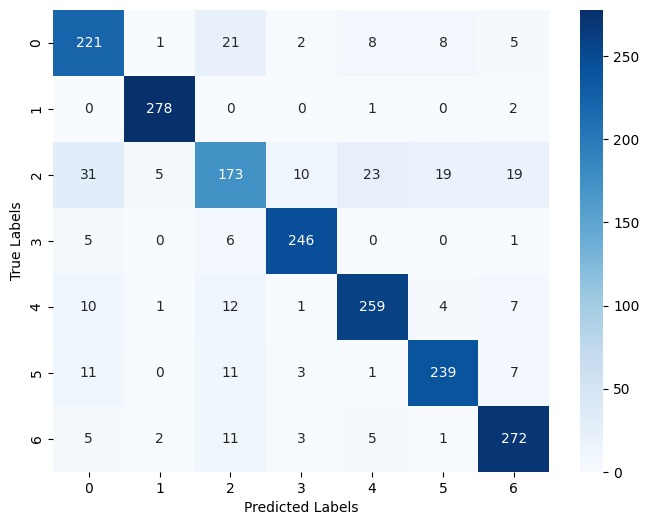

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
conf_matrix = confusion_matrix(labels, preds_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


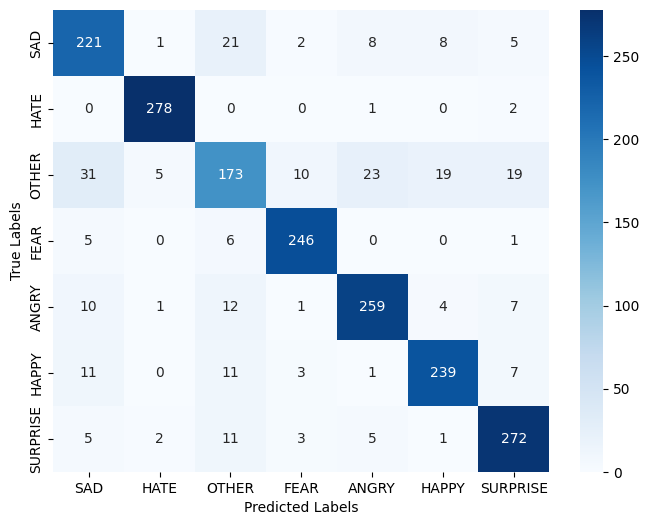

In [38]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
# Class labels
class_labels = ['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE']

preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


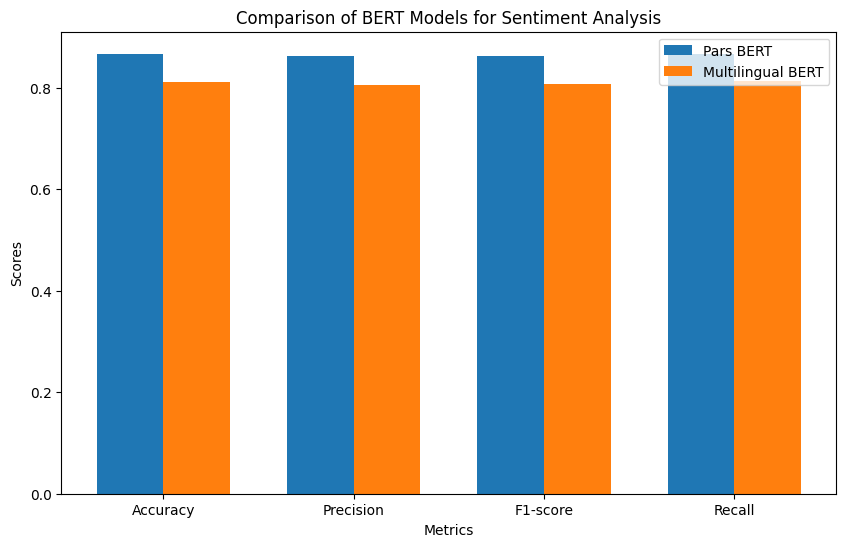

In [27]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of BERT Models for Sentiment Analysis')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

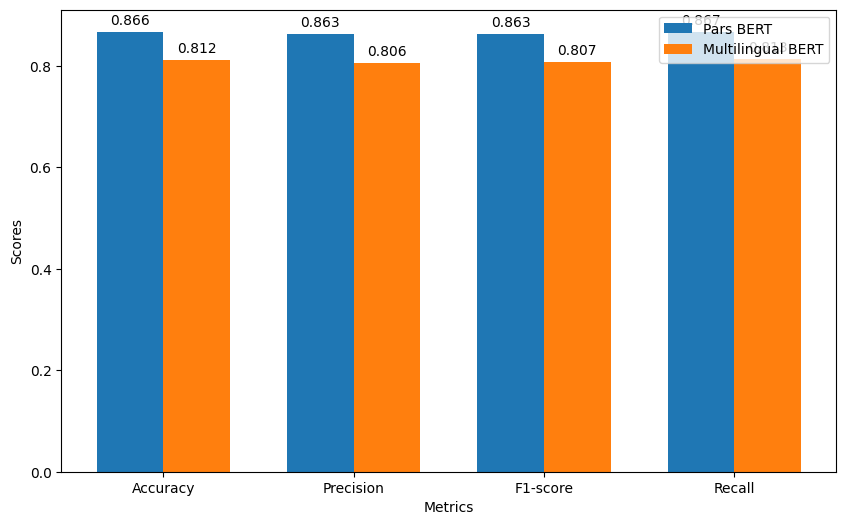

In [28]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
def add_values_on_top(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values_on_top(bar1)
add_values_on_top(bar2)
plt.show()


In [45]:

new_comments = ["آیتالله نوری همدانی کاخنشینی و تجملگرایی مدیران و مسئولان در اسلام مذموم است به وضعیت معیشتی بغرنج طلاب رسیدگی شودتسنیمappy today!"]

# Tokenize and encode the new comments
new_input_ids = []
new_attention_masks = []
new_token_type_ids = []

for new_comment in new_comments:
    encoded_dict = tokenizer.encode_plus(
        new_comment,
        truncation=True,
        add_special_tokens=True,
        max_length=270,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        return_token_type_ids=True,
    )
    new_input_ids.append(encoded_dict['input_ids'])
    new_attention_masks.append(encoded_dict['attention_mask'])
    new_token_type_ids.append(encoded_dict['token_type_ids'])

# Concatenate the tensors
new_input_ids = torch.cat(new_input_ids, dim=0)
new_attention_masks = torch.cat(new_attention_masks, dim=0)
new_token_type_ids = torch.cat(new_token_type_ids, dim=0)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(new_input_ids.to(device), token_type_ids=new_token_type_ids.to(device),
                    attention_mask=new_attention_masks.to(device))
predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Map the predictions back to label names
label_mapping = {0: 'SAD', 1: 'HATE', 2: 'OTHER', 3: 'FEAR', 4: 'ANGRY', 5: 'HAPPY', 6: 'SURPRISE'}
predicted_labels = [label_mapping[pred] for pred in predictions]

# Print the predictions
for comment, label in zip(new_comments, predicted_labels):
    print(f"Comment: {comment} --> Predicted Label: {label}")


Comment: آیتالله نوری همدانی کاخنشینی و تجملگرایی مدیران و مسئولان در اسلام مذموم است به وضعیت معیشتی بغرنج طلاب رسیدگی شودتسنیمappy today! --> Predicted Label: OTHER


In [44]:
df_test['tweets'][66]

'آیتالله نوری همدانی کاخنشینی و تجملگرایی مدیران و مسئولان در اسلام مذموم است به وضعیت معیشتی بغرنج طلاب رسیدگی شودتسنیم'

In [29]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=db7d0b1ed6a47c57ea7e2fc75afa5156292f429085356639ba29dddd44d0038b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [81]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["SAD", "HATE", "OTHER", "FEAR", "ANGRY", "HAPPY", "SURPRISE"])

# Example sentence for interpretation
example_sentence = df_test['tweets'][600]

def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()

explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()


In [82]:
explanation.save_to_file('lime-parsBERT.html')

In [83]:
explanation.as_list()

[('ميترسم', -0.08030890735421363),
 ('از', 0.040469328466562135),
 ('هاي', 0.040107401713037304),
 ('خندان', -0.040078964211526034),
 ('گل', -0.03424567990709491),
 ('انتخابات', 0.02782258650430512),
 ('من', -0.00528650005639861),
 ('اين', 0.001992521552196867)]

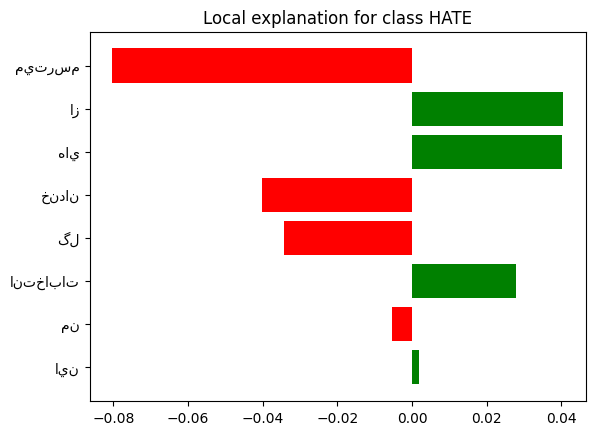

In [84]:
fig = explanation.as_pyplot_figure()

In [72]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["SAD", "HATE", "OTHER", "FEAR", "ANGRY", "HAPPY", "SURPRISE"])

# Example sentence for interpretation
example_sentence ="لعنت تحریم بانیش چی هست"

def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()

explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()


In [75]:
explanation.as_list()


[('چی', -0.07592663206995298),
 ('هست', -0.07306789311435867),
 ('تحریم', -0.04638443617000227),
 ('لعنت', 0.024833599051241842),
 ('بانیش', -0.017219133982430614)]

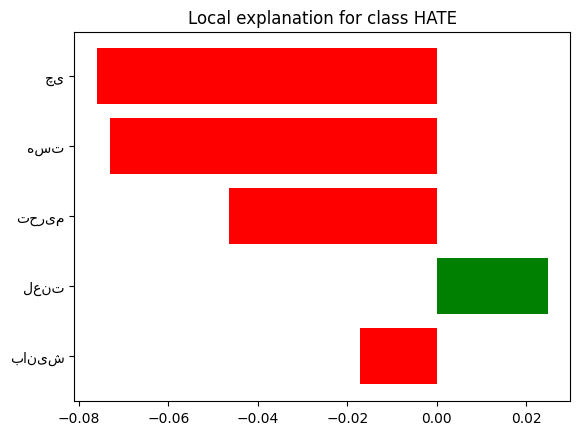

In [76]:
fig = explanation.as_pyplot_figure()

In [77]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["SAD", "HATE", "OTHER", "FEAR", "ANGRY", "HAPPY", "SURPRISE"])

# Example sentence for interpretation
example_sentence ="مردم بايد آزاد دوست انتخاب كنند حتى نامطلوب سقلمه"

def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()

explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()


In [78]:
explanation.save_to_file('lime-parsBERT.html')


In [79]:
explanation.as_list()


[('انتخاب', -0.0027492988917405107),
 ('نامطلوب', 0.0017157372786404468),
 ('آزاد', -0.0015018267203041416),
 ('كنند', -0.0014733373780228206),
 ('بايد', -0.0006990240962813425),
 ('مردم', -0.0005225005550878363),
 ('حتى', 0.00044218731771817276),
 ('دوست', 0.0002418695843154802),
 ('سقلمه', 0.00013454443447971328)]

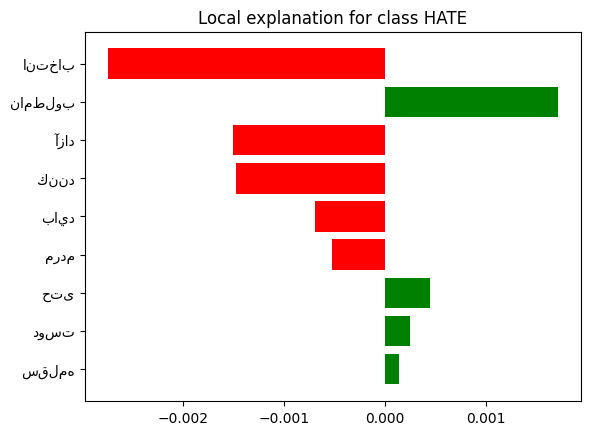

In [80]:
fig = explanation.as_pyplot_figure()

In [85]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["SAD", "HATE", "OTHER", "FEAR", "ANGRY", "HAPPY", "SURPRISE"])

# Example sentence for interpretation
example_sentence =df_test['tweets'][900]

def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()

explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()


In [86]:
explanation.save_to_file('lime-parsBERT.html')


In [87]:
explanation.as_list()


[('درود', -0.0003656077973445686),
 ('عزیزی', -0.0002533813156158613),
 ('سلام', -0.0001947707165428602),
 ('ک', 0.0001817051240644858),
 ('وپناه', -0.00017125138707800325),
 ('راه', -0.00017088290508355289),
 ('و', -0.0001683799869907827),
 ('هموطنان', 0.00014315768225861843),
 ('بر', 0.00014090765876618934),
 ('کنن', 0.000133329114219704)]

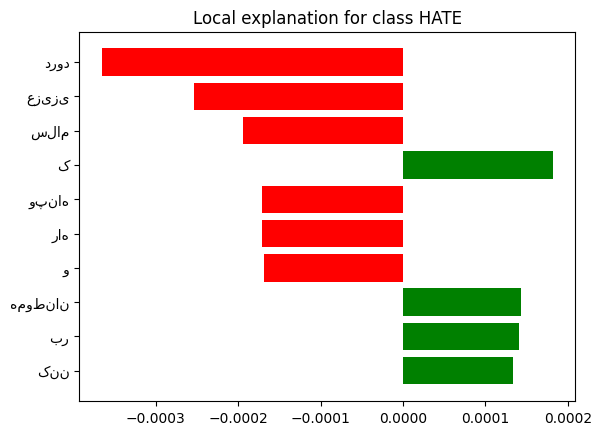

In [88]:
fig = explanation.as_pyplot_figure()